# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

https://github.com/petrobras/3W

In [28]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import joblib
import pickle

In [3]:
df = pd.read_parquet('real_instances.parquet.gzip') 

In [4]:
df.shape

(14516197, 12)

In [5]:
df.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0.0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,NaN,0.0,0.0


### Análise inicial

In [6]:
df.id.nunique()

1013

In [7]:
df['label'].value_counts()

label
0    9903155
4    2462076
3     569152
5     552529
7     466338
1     312136
2     194233
6      56578
Name: count, dtype: int64

In [8]:
df['class'].value_counts()

class
0.0      10003293
4.0       2462076
3.0        569152
105.0      317565
107.0      283262
101.0       95658
102.0       65130
7.0         25870
2.0         16100
5.0         13031
6.0         12951
1.0         10417
106.0        6252
Name: count, dtype: int64

In [9]:
pd.crosstab(df['well'], df['label'])

label,0,1,2,3,4,5,6,7
well,,,,,,,,
WELL-00001,1652442,58468,0,17976,261457,0,0,73033
WELL-00002,3641159,24017,9121,0,807601,0,47869,0
WELL-00003,463543,0,35406,0,0,0,0,0
WELL-00004,85505,0,0,0,307674,0,8709,0
WELL-00005,979611,0,0,0,271525,0,0,0
WELL-00006,2058403,229651,0,0,0,0,0,305517
WELL-00007,14370,0,0,0,71651,0,0,0
WELL-00008,1008122,0,0,0,0,0,0,0
WELL-00009,0,0,6738,0,0,0,0,0


In [10]:
pd.crosstab(df['class'], df['label'])

label,0,1,2,3,4,5,6,7
class,,,,,,,,
0.0,9439612,195376,52017,0,0,127930,36319,152039
1.0,0,10417,0,0,0,0,0,0
2.0,0,0,16100,0,0,0,0,0
3.0,0,0,0,569152,0,0,0,0
4.0,0,0,0,0,2462076,0,0,0
5.0,0,0,0,0,0,13031,0,0
6.0,0,0,0,0,0,0,12951,0
7.0,0,0,0,0,0,0,0,25870
101.0,0,95658,0,0,0,0,0,0


In [11]:
df.drop_duplicates(subset=['id'], keep='last').groupby("label")["id"].count()

label
0    588
1      5
2     22
3     32
4    344
5     11
6      6
7      5
Name: id, dtype: int64

In [12]:
df.isnull().sum()/len(df)

label         0.000000
well          0.000000
id            0.000000
P-PDG         0.000580
P-TPT         0.008007
T-TPT         0.008007
P-MON-CKP     0.077959
T-JUS-CKP     0.113279
P-JUS-CKGL    0.071501
T-JUS-CKGL    1.000000
QGL           0.191125
class         0.043775
dtype: float64

In [13]:
df['target'] = 1
df.loc[(df['label']==0)&(df['class']==0), "target"] = 0

In [14]:
df.target.value_counts()

target
0    9439612
1    5076585
Name: count, dtype: int64

In [15]:
df.target.value_counts(normalize=True)

target
0    0.650281
1    0.349719
Name: proportion, dtype: float64

In [16]:
df2 = df.drop(['T-JUS-CKGL'], axis=1)
df2 = df2.dropna()

In [17]:
del df

In [18]:
df2.shape

(11108977, 12)

In [19]:
df2.target.value_counts(normalize=True)

target
0    0.663057
1    0.336943
Name: proportion, dtype: float64

In [20]:
df3 = df2.reset_index()
df3.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
0,2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
1,2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2,2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
3,2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
4,2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [21]:
df3['well'].value_counts()

well
WELL-00002    4518972
WELL-00006    2588359
WELL-00001    2062763
WELL-00014     699734
WELL-00010     601704
WELL-00017     382288
WELL-00018      87162
WELL-00007      86021
WELL-00015      54811
WELL-00016      20465
WELL-00009       6698
Name: count, dtype: int64

In [22]:
df3.dtypes

timestamp     datetime64[ns]
label                  int64
well                  object
id                    object
P-PDG                float64
P-TPT                float64
T-TPT                float64
P-MON-CKP            float64
T-JUS-CKP            float64
P-JUS-CKGL           float64
QGL                  float64
class                float64
target                 int64
dtype: object

In [23]:
df3['anomesdia'] = pd.to_datetime(df3['timestamp'])
df3['anomesdia'] = df3['anomesdia'].dt.strftime('%Y-%m-%d')

In [24]:
df3.anomesdia.value_counts()

anomesdia
2017-08-26    172019
2017-08-24    171969
2017-08-25    171739
2017-08-27    171667
2017-08-01    161586
               ...  
2017-05-10      3601
2013-12-08      3600
2013-12-11      3585
2017-04-07      3578
2013-12-16         1
Name: count, Length: 163, dtype: int64

### Time Series - per day

In [31]:
df4 = df3.groupby(['anomesdia'])[['target', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']].mean()

In [32]:
df4 = df4.reset_index()
df4['timestamp'] = pd.to_datetime(df4['anomesdia'])
df4.head()

,anomesdia,target,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp
0,2013-11-04,1.000000,0.0,1.364051e+07,65.330549,6.954670e+06,173.0961,2.854692e+06,0.0,2013-11-04
1,2013-12-08,1.000000,0.0,1.662663e+07,118.146029,7.261317e+06,173.0961,4.767741e+06,0.0,2013-12-08
2,2013-12-09,1.000000,0.0,1.682933e+07,118.066459,7.509941e+06,173.0961,4.720698e+06,0.0,2013-12-09
3,2013-12-11,0.000000,0.0,1.663968e+07,118.047446,7.328442e+06,173.0961,3.394900e+06,0.0,2013-12-11
4,2013-12-12,0.308036,0.0,1.663583e+07,118.112567,7.311691e+06,173.0961,3.846629e+06,0.0,2013-12-12


In [35]:
df4['target'] = df4['target'].apply(lambda x: 1 if x>0 else 0)
df4.target.value_counts()

target
0    87
1    76
Name: count, dtype: int64

In [36]:
df4[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']].describe()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
count,1.630000e+02,1.630000e+02,163.000000,1.630000e+02,163.000000,1.630000e+02,163.000000
mean,-3.619988e+40,2.038850e+07,104.470272,4.473952e+06,75.568523,1.361328e+08,0.202075
std,2.041206e+41,8.936436e+07,24.958741,3.079866e+06,37.287092,4.641398e+08,0.489567
min,-1.180116e+42,5.121908e+06,13.660866,8.775111e+05,21.477278,-4.976717e+05,0.000000
25%,0.000000e+00,8.607027e+06,114.771250,1.725312e+06,61.472450,2.322900e+06,0.000000
50%,0.000000e+00,1.415794e+07,117.147107,3.198275e+06,72.655228,3.054184e+06,0.000000
75%,2.381391e+07,1.632493e+07,117.585771,6.136441e+06,76.385463,6.219189e+06,0.000000
max,4.485805e+07,1.153117e+09,119.025942,1.243904e+07,173.096100,2.024286e+09,1.931549


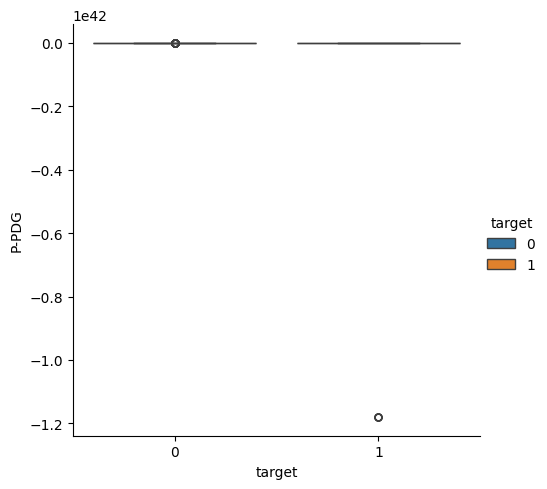

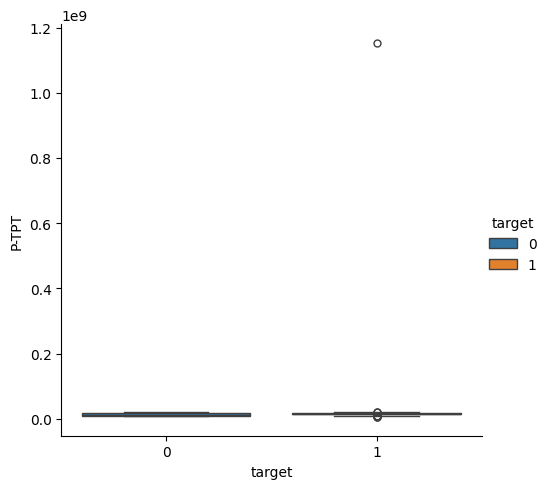

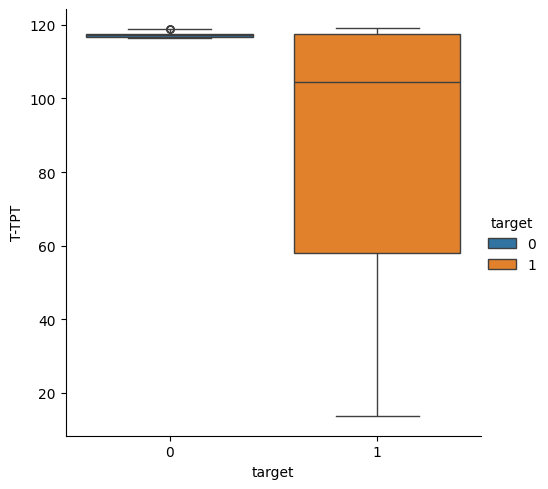

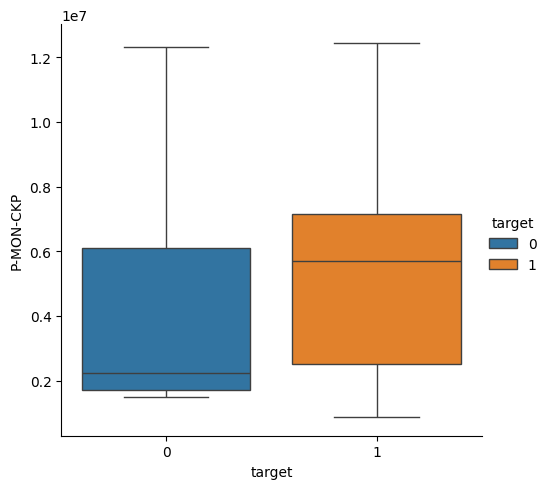

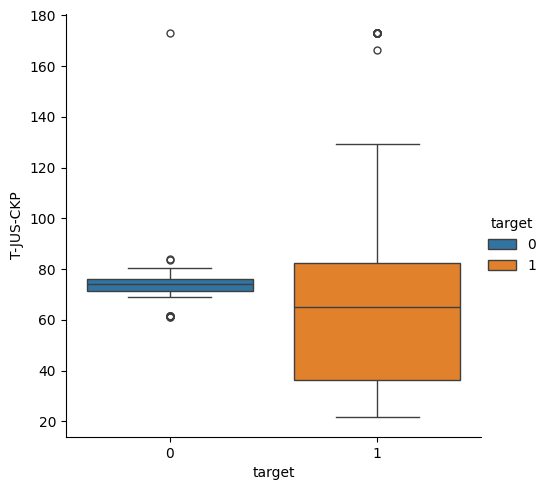

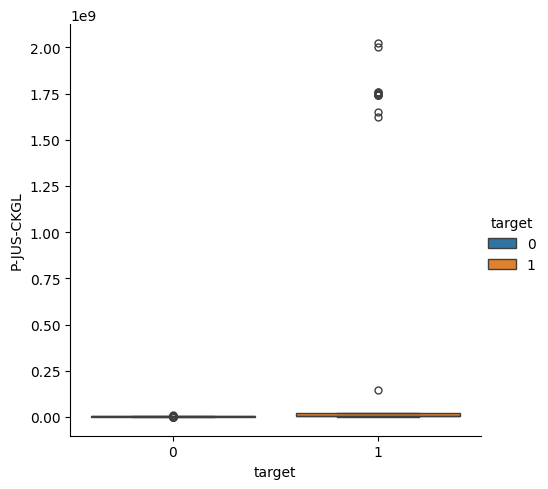

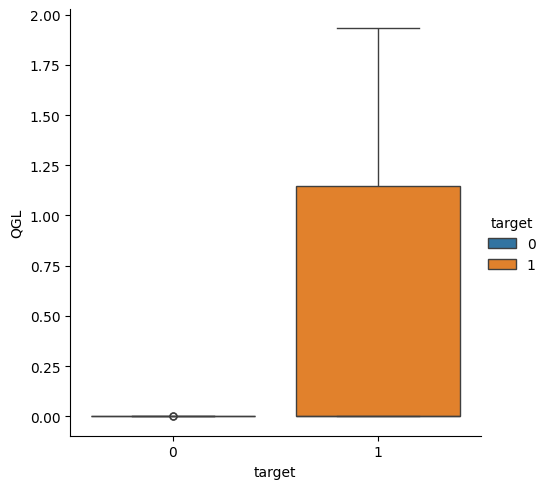

In [38]:
warnings.filterwarnings('ignore')
orders = [0, 1]
g = sns.catplot(y="P-PDG",x="target", hue="target", data=df4,kind="box", order = orders)
g = sns.catplot(y="P-TPT",x="target",  hue="target", data=df4,kind="box", order = orders)
g = sns.catplot(y="T-TPT",x="target", hue="target", data=df4,kind="box", order = orders)
g = sns.catplot(y="P-MON-CKP",x="target",  hue="target", data=df4,kind="box", order = orders)
g = sns.catplot(y="T-JUS-CKP",x="target",  hue="target", data=df4,kind="box", order = orders)
g = sns.catplot(y="P-JUS-CKGL",x="target", hue="target", data=df4,kind="box", order = orders)
g = sns.catplot(y="QGL",x="target",  hue="target", data=df4,kind="box", order = orders)

Text(0.5, 1.0, 'P-PDG')

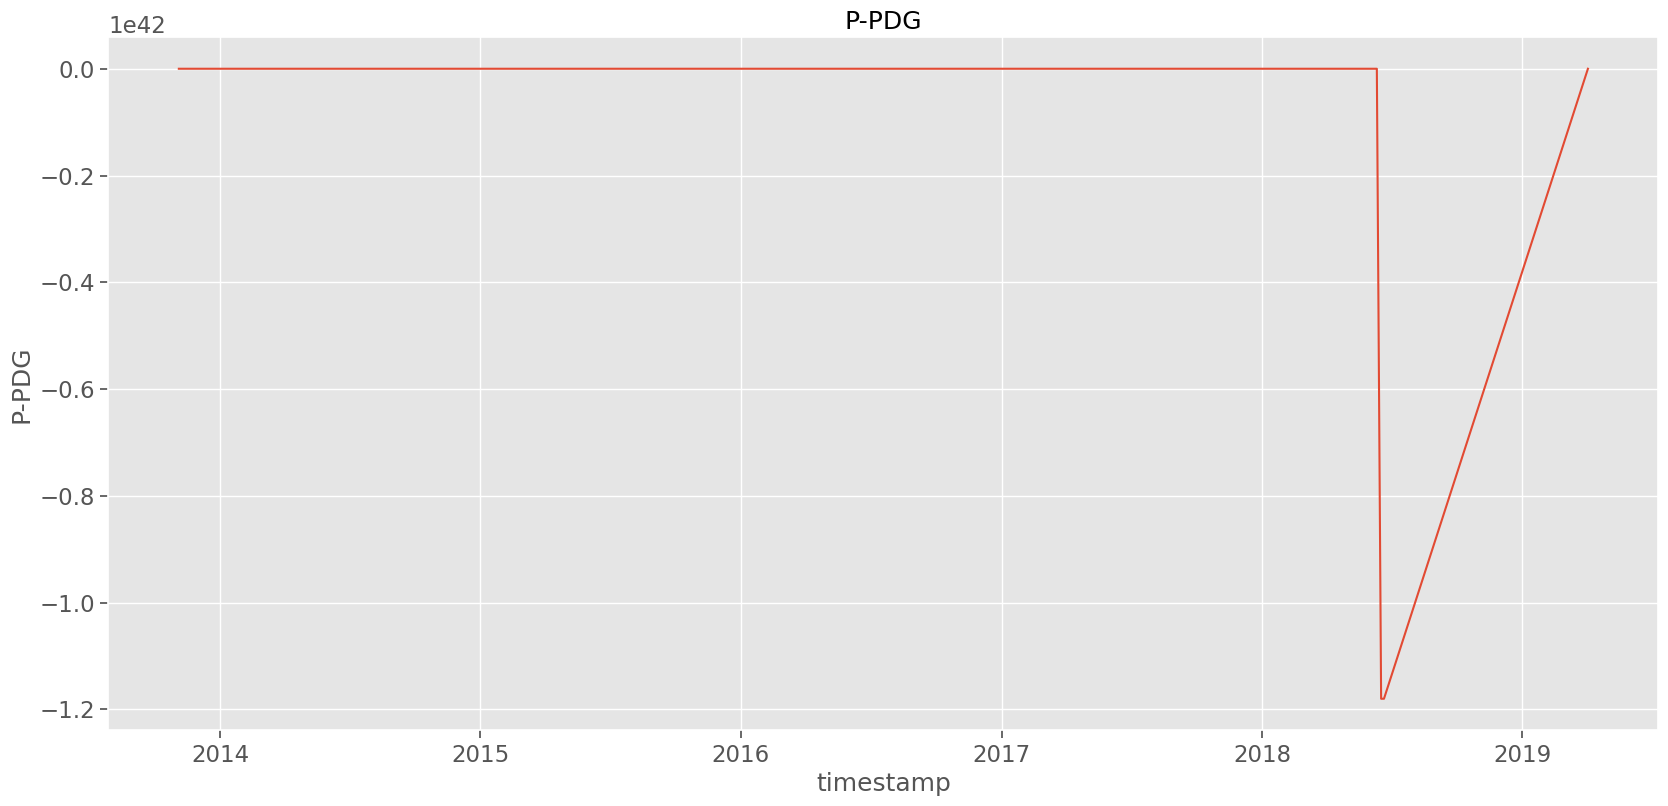

In [39]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-PDG', data=df4, palette='Blues_d')
plt.title('P-PDG')

Text(0.5, 1.0, 'P-TPT')

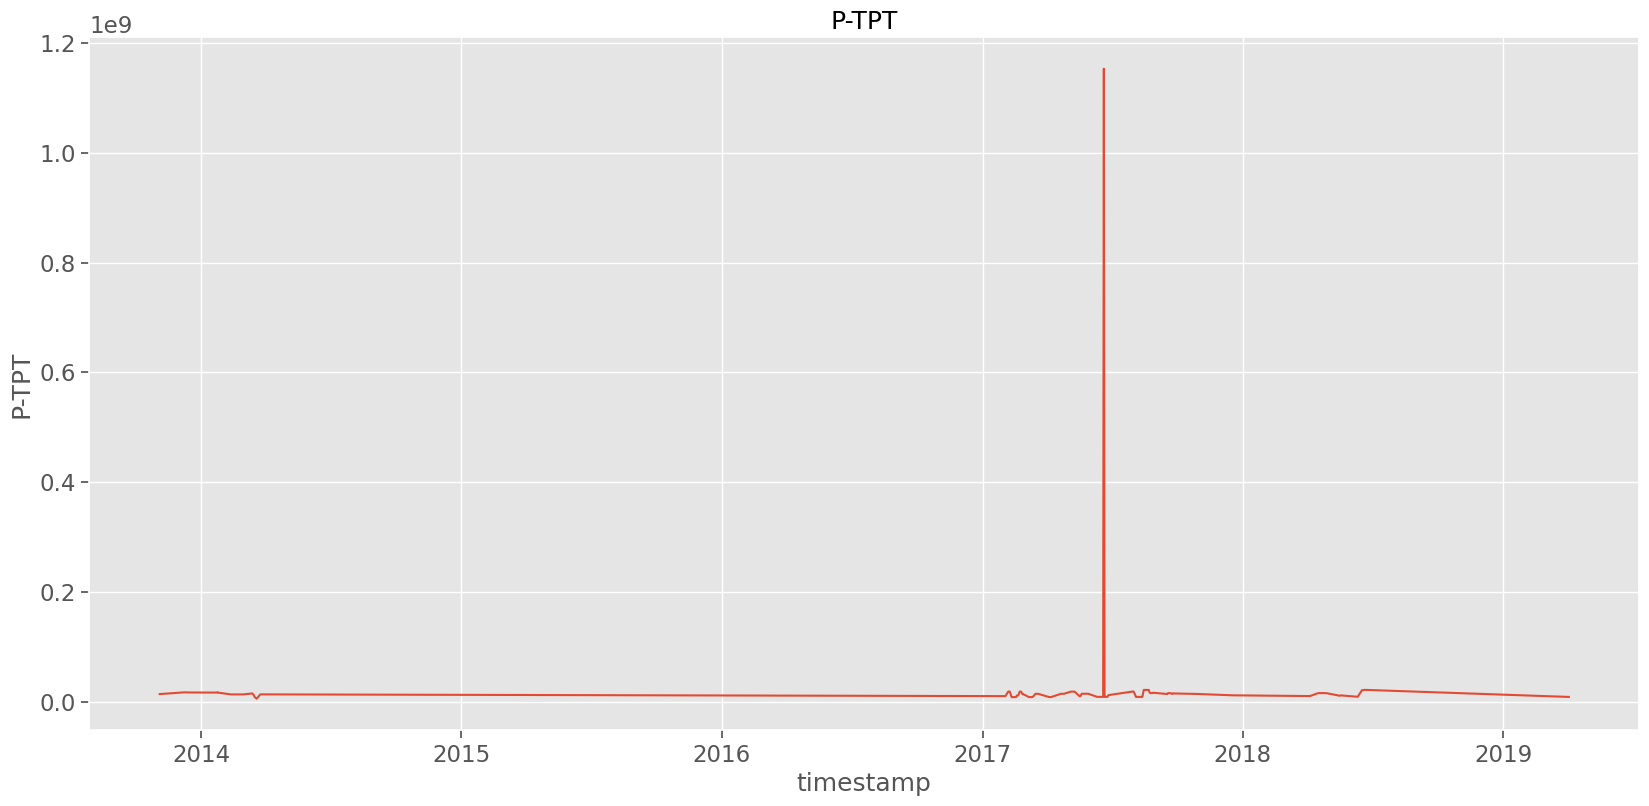

In [40]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-TPT', data=df4, palette='Blues_d')
plt.title('P-TPT')

Text(0.5, 1.0, 'T-TPT')

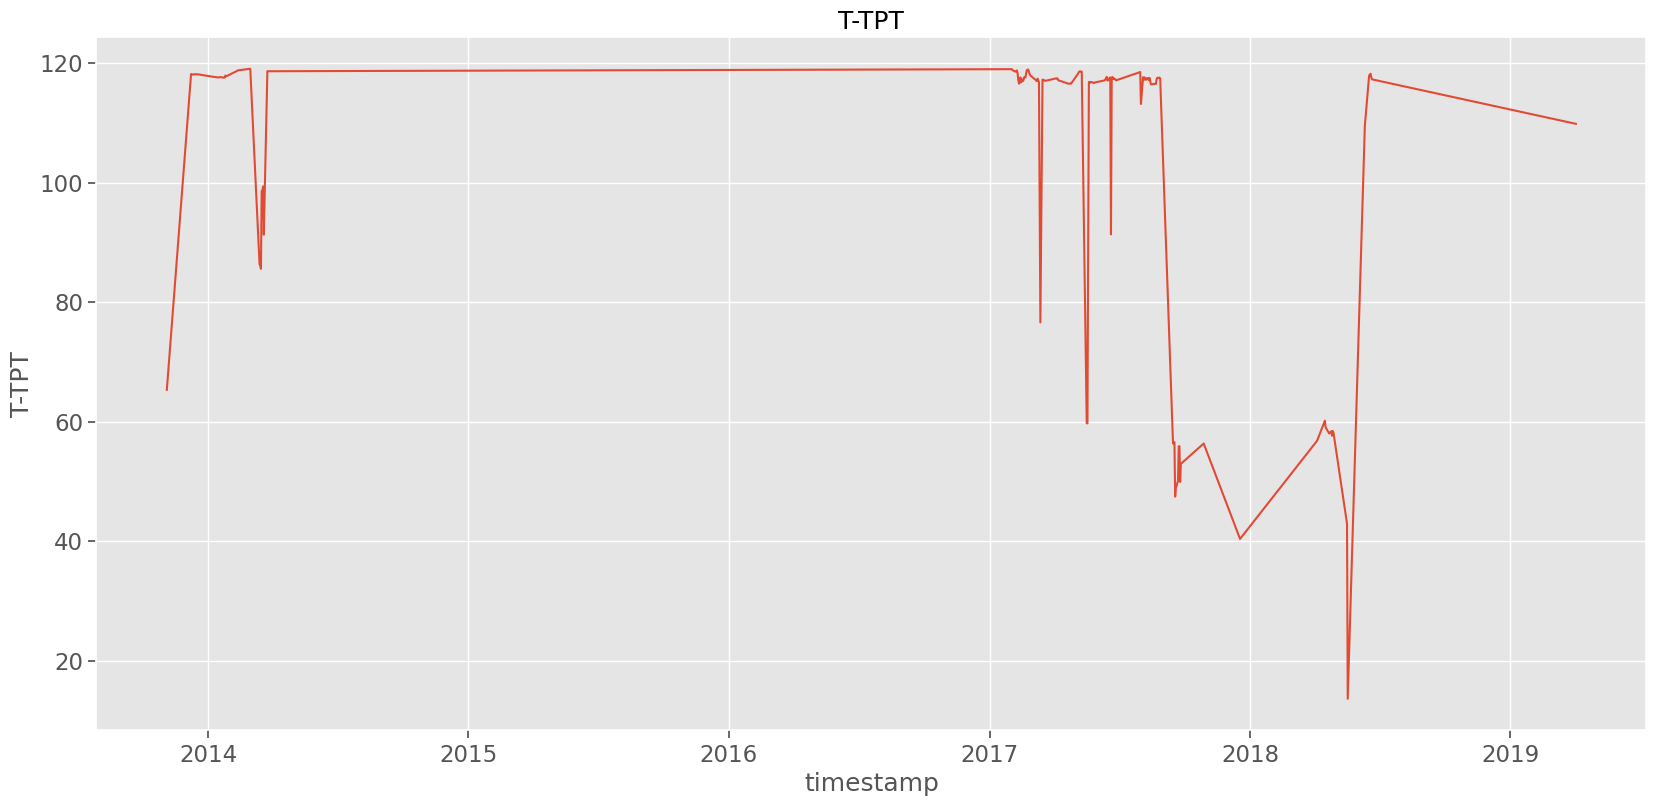

In [41]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='T-TPT', data=df4, palette='Blues_d')
plt.title('T-TPT')

Text(0.5, 1.0, 'T-JUS-CKP')

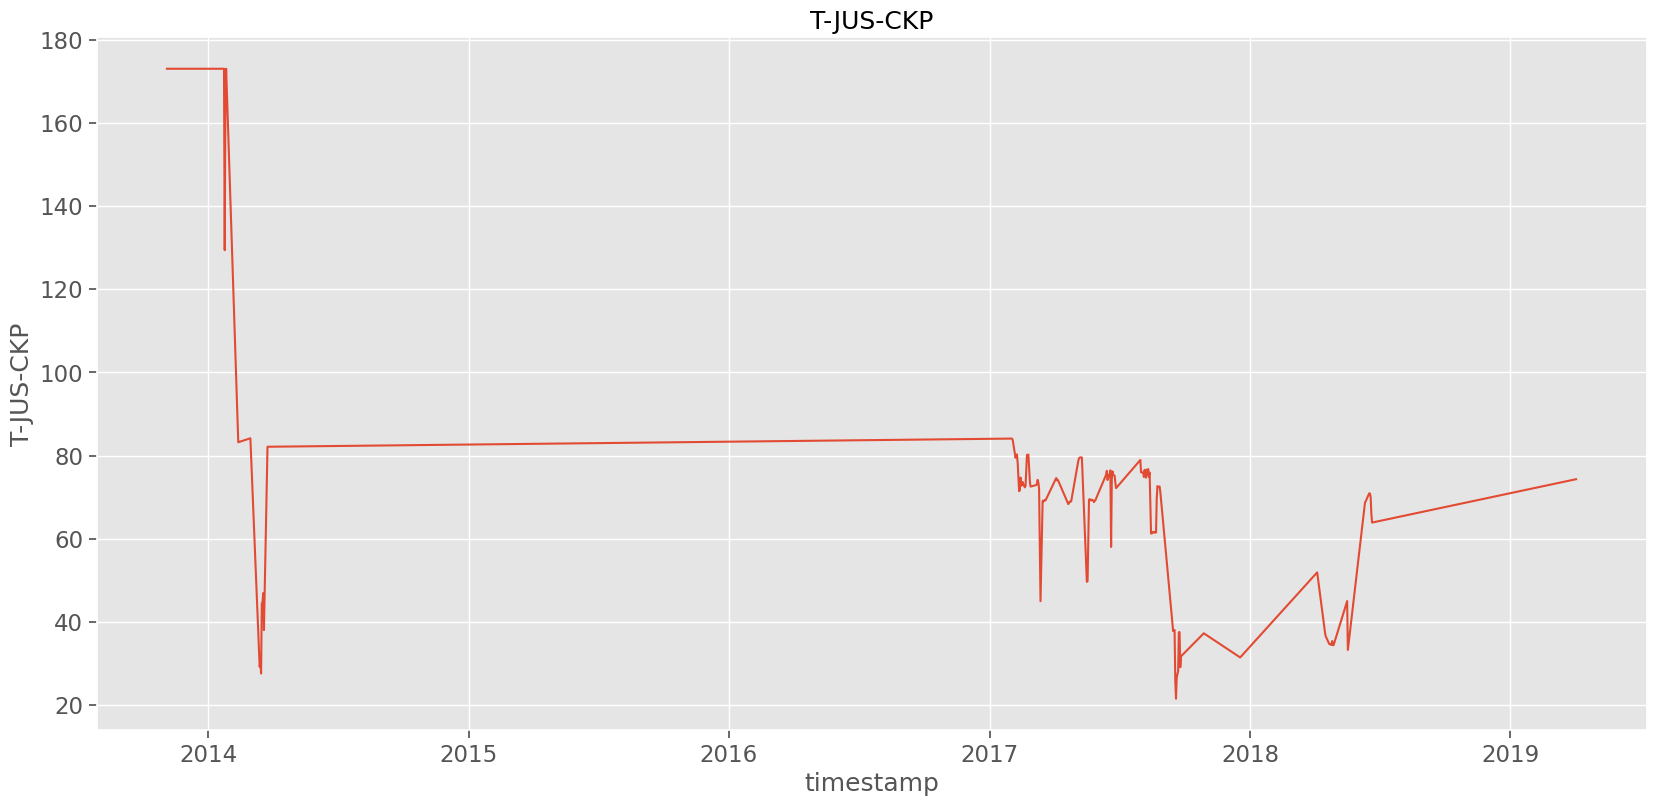

In [42]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='T-JUS-CKP', data=df4, palette='Blues_d')
plt.title('T-JUS-CKP')

Text(0.5, 1.0, 'P-JUS-CKGL')

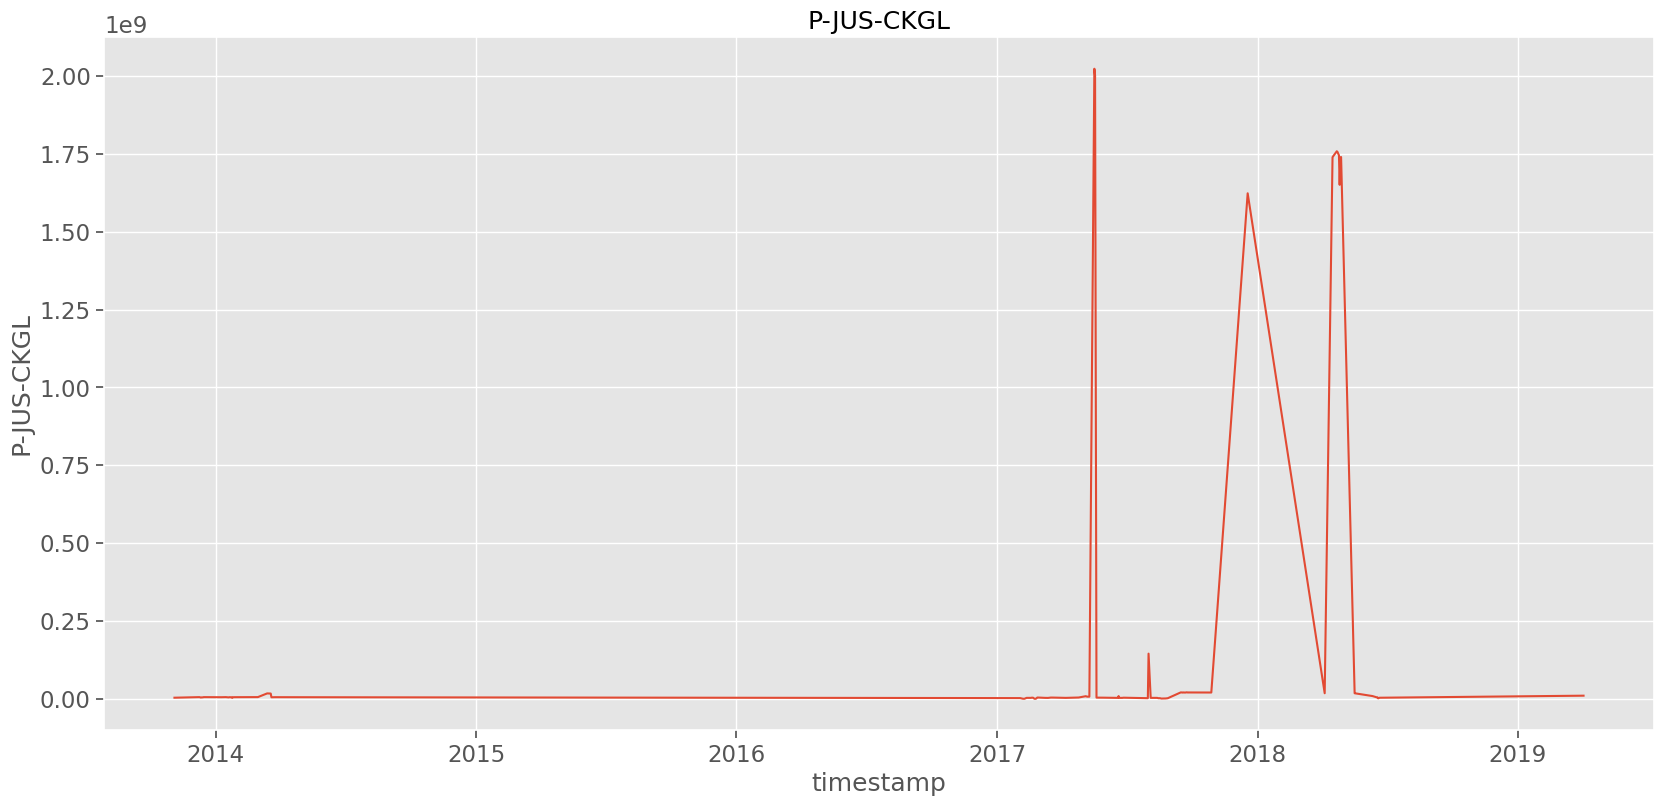

In [43]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-JUS-CKGL', data=df4, palette='Blues_d')
plt.title('P-JUS-CKGL')

Text(0.5, 1.0, 'P-MON-CKP')

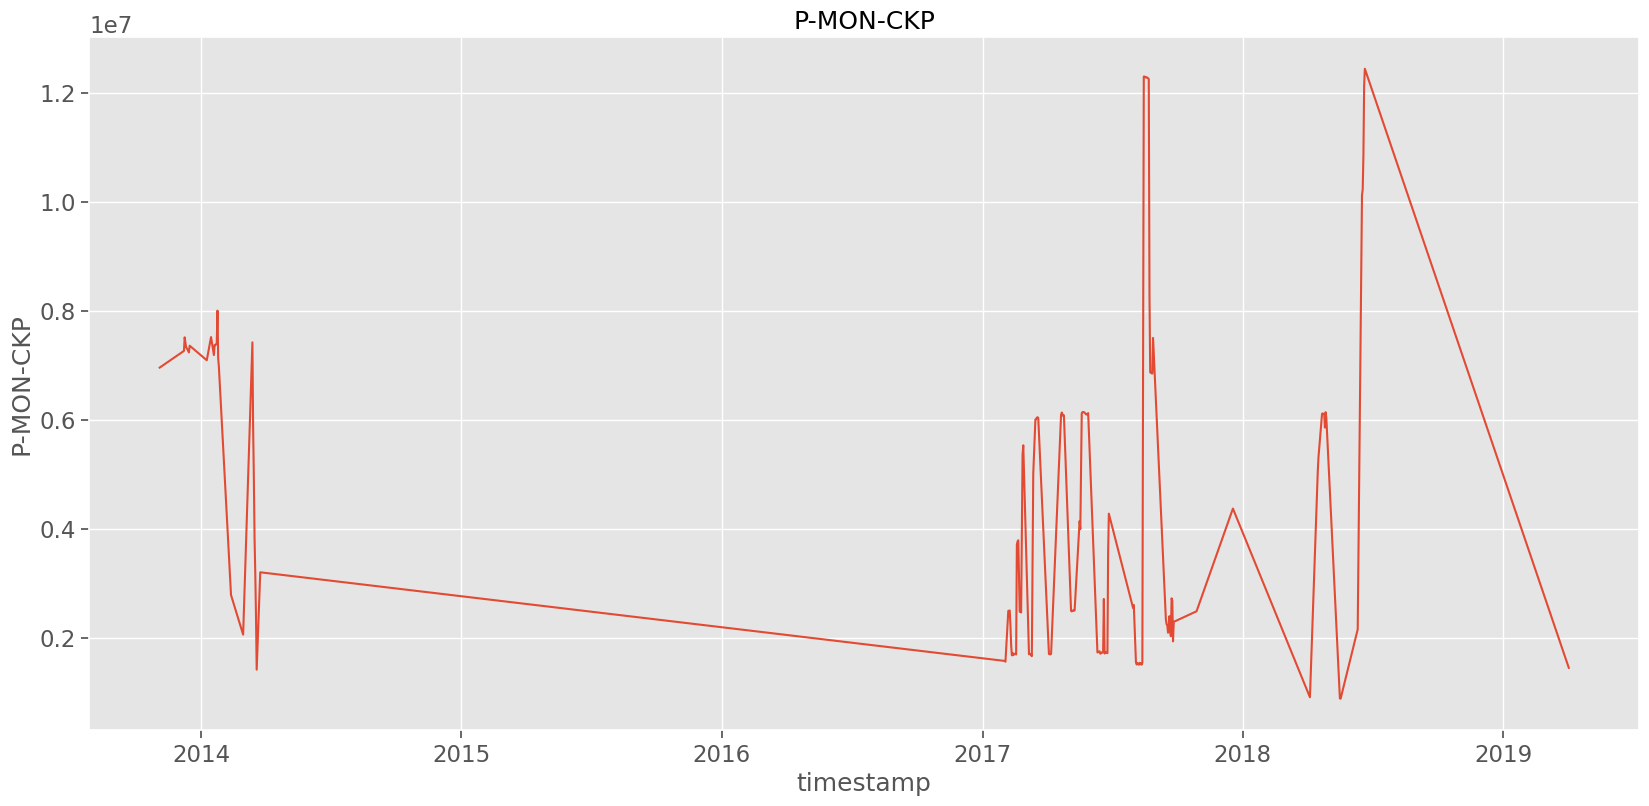

In [44]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-MON-CKP', data=df4, palette='Blues_d')
plt.title('P-MON-CKP')

Text(0.5, 1.0, 'QGL')

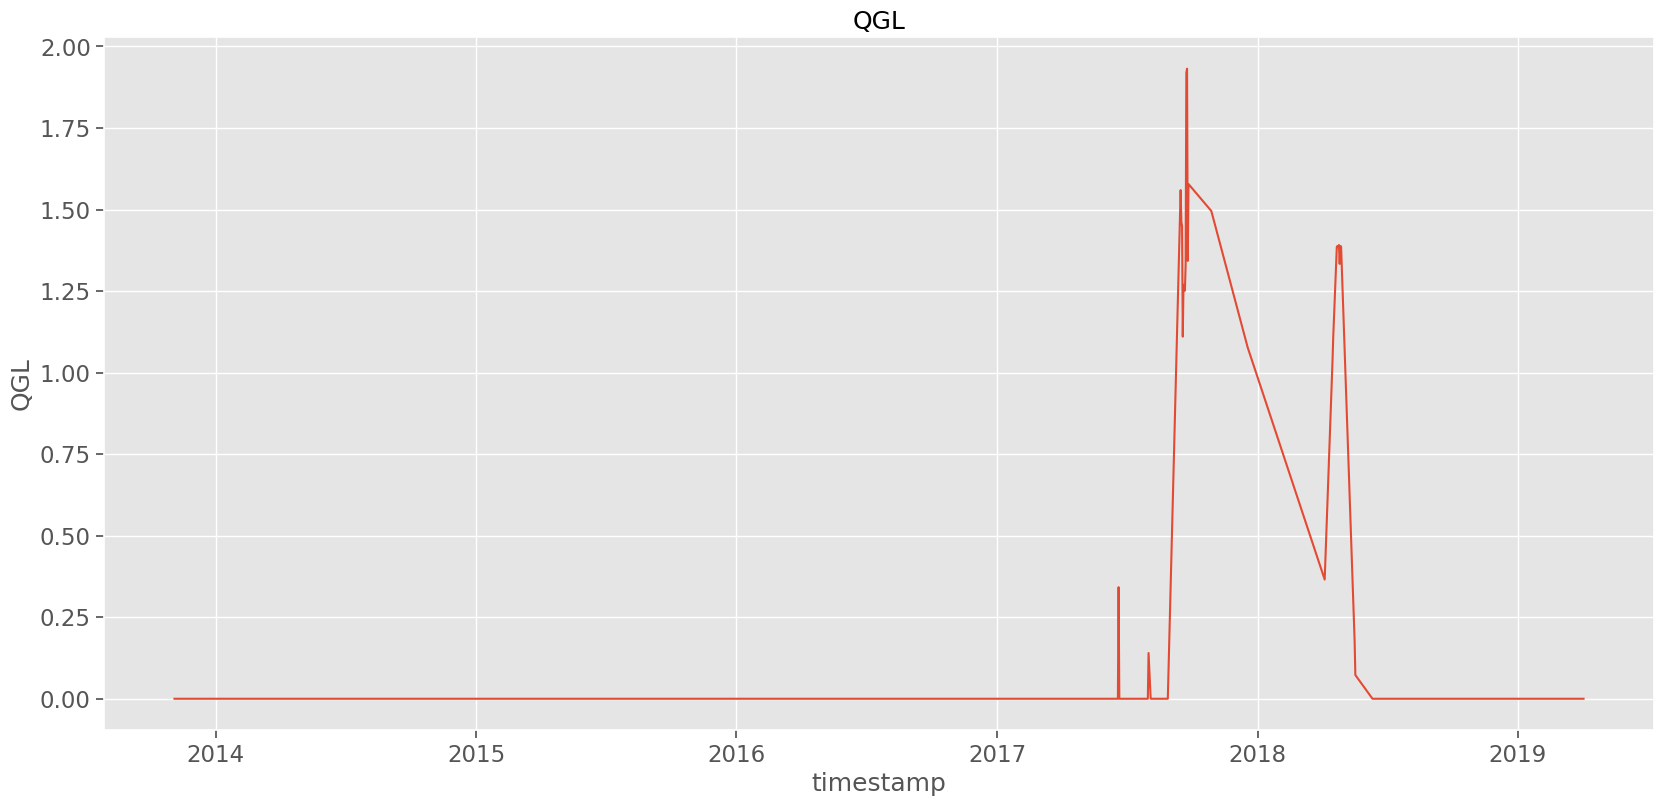

In [45]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='QGL', data=df4, palette='Blues_d')
plt.title('QGL')

### Time Series - well per day

In [46]:
df4 = df3.groupby(['well', 'anomesdia'])[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']].mean()

In [47]:
df4 = df4.reset_index()
df4['timestamp'] = pd.to_datetime(df4['anomesdia'])
df4.head()

,well,anomesdia,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp
0,WELL-00001,2014-01-24,0.0,1.833705e+07,116.959242,9.231608e+06,75.224870,-3.009178e+05,0.0,2014-01-24
1,WELL-00001,2014-01-25,0.0,1.745830e+07,117.587273,7.956221e+06,79.097792,-3.009178e+05,0.0,2014-01-25
2,WELL-00001,2017-02-01,0.0,9.994807e+06,118.955002,1.571738e+06,84.092209,1.571248e+06,0.0,2017-02-01
3,WELL-00001,2017-02-02,0.0,9.897731e+06,118.782145,1.557064e+06,83.768487,1.575817e+06,0.0,2017-02-02
4,WELL-00001,2017-02-18,0.0,1.384466e+07,117.692652,5.790406e+06,70.310990,3.372657e+06,0.0,2017-02-18


In [53]:
for i in df4.well.unique().tolist():
    df5 = df4[df4.well==i].copy()
    print('well', i)
    print(df5[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']].describe())

well WELL-00001
              P-PDG         P-TPT       T-TPT     P-MON-CKP  T-JUS-CKP  \
count  3.600000e+01  3.600000e+01   36.000000  3.600000e+01  36.000000   
mean   4.790595e+05  1.331933e+07  117.362643  5.147123e+06  73.101167   
std    8.445460e+06  2.148737e+06    0.777387  2.073526e+06   6.005626   
min   -6.887865e+06  9.633533e+06  116.521556  1.477830e+06  68.309617   
25%    0.000000e+00  1.343011e+07  116.756754  5.485834e+06  69.173819   
50%    0.000000e+00  1.409318e+07  117.017110  6.035075e+06  69.415943   
75%    0.000000e+00  1.420872e+07  117.949574  6.113975e+06  76.193101   
max    3.826583e+07  1.833705e+07  118.955002  9.231608e+06  84.092209   

         P-JUS-CKGL        QGL  
count  3.600000e+01  36.000000  
mean   2.386806e+06   0.000010  
std    1.451920e+06   0.000057  
min   -3.009178e+05   0.000000  
25%    1.574675e+06   0.000000  
50%    3.115577e+06   0.000000  
75%    3.319697e+06   0.000000  
max    3.461234e+06   0.000345  
well WELL-00002
    

In [49]:
df4.dtypes

well                  object
anomesdia             object
P-PDG                float64
P-TPT                float64
T-TPT                float64
P-MON-CKP            float64
T-JUS-CKP            float64
P-JUS-CKGL           float64
QGL                  float64
timestamp     datetime64[ns]
dtype: object

In [50]:
df3.shape

(11108977, 14)

In [51]:
df4.shape

# df2.sample(frac=0.001)

(181, 10)

Text(0.5, 1.0, 'P-PDG')

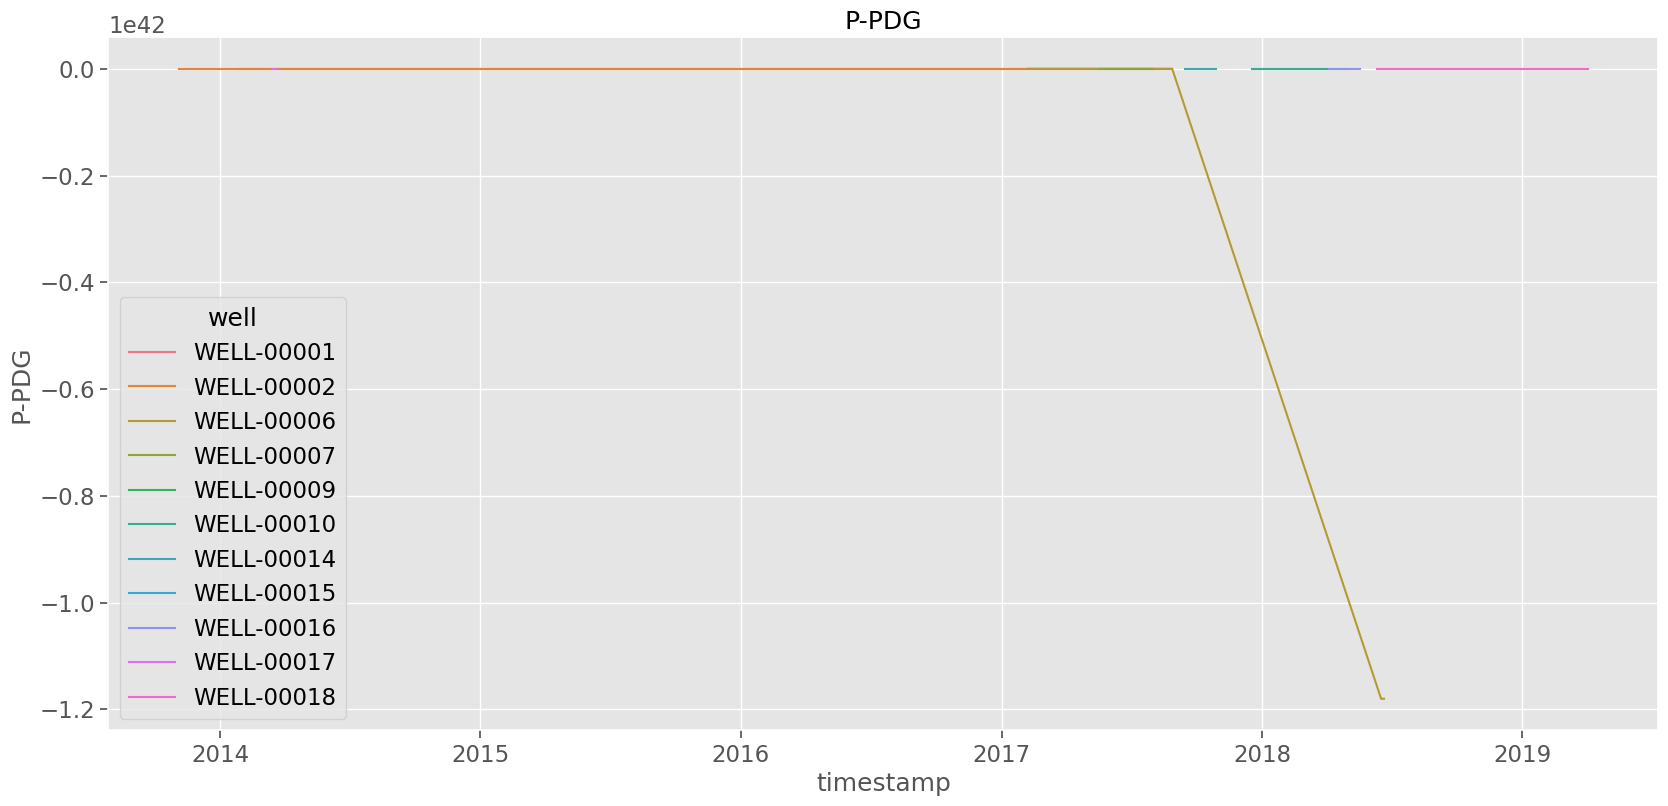

In [31]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
# g = sns.lineplot(x='timestamp', y='P-PDG', data=df4, palette='Blues_d')
g = sns.lineplot(x='timestamp', y='P-PDG', data=df4, hue='well')
plt.title('P-PDG')

Text(0.5, 1.0, 'P-TPT')

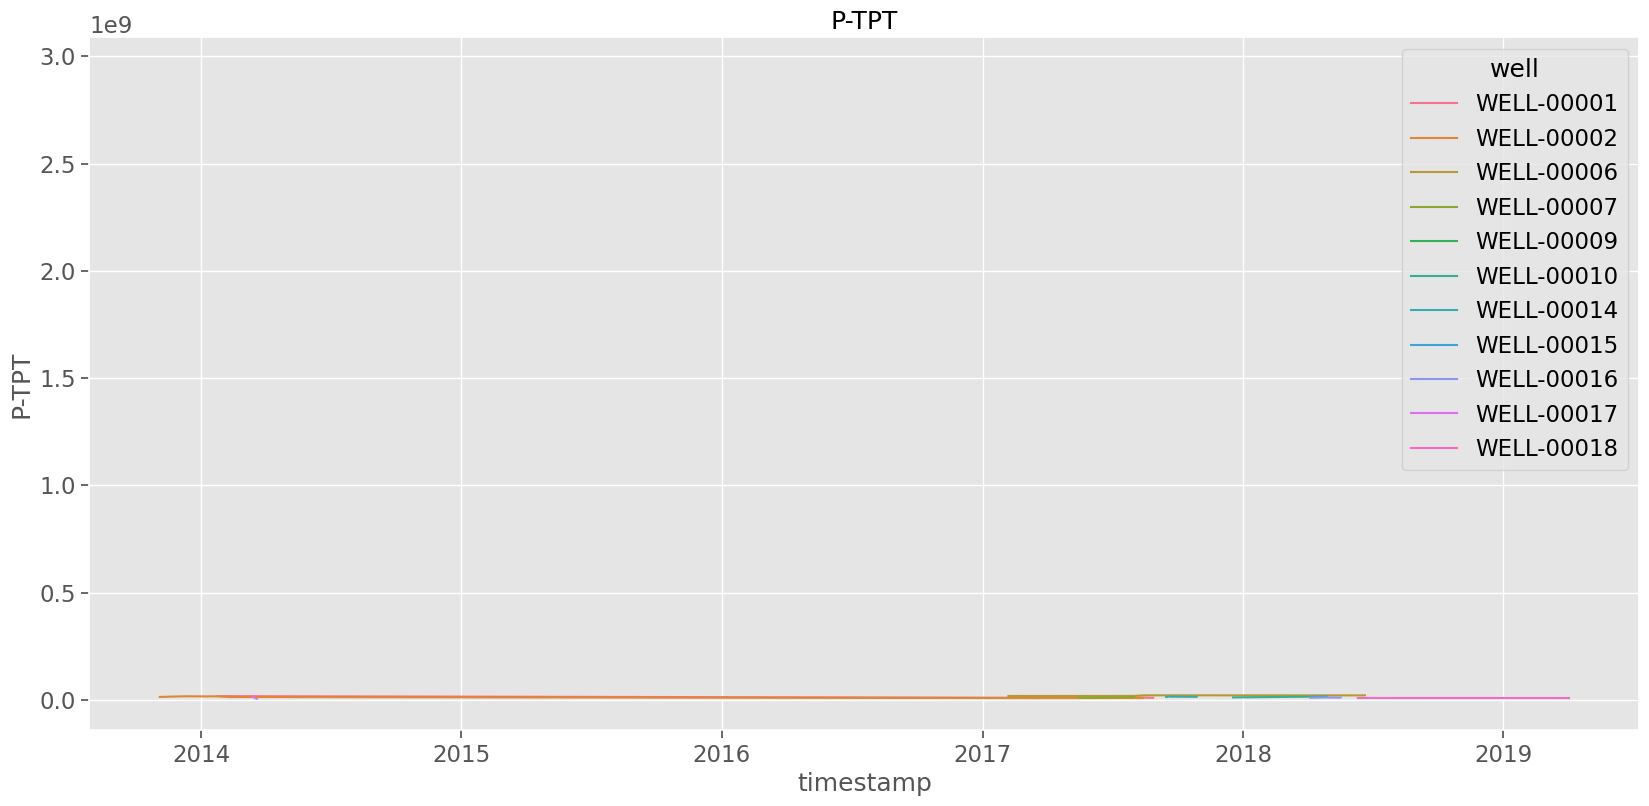

In [32]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-TPT', data=df4, hue='well')
plt.title('P-TPT')

Text(0.5, 1.0, 'T-TPT')

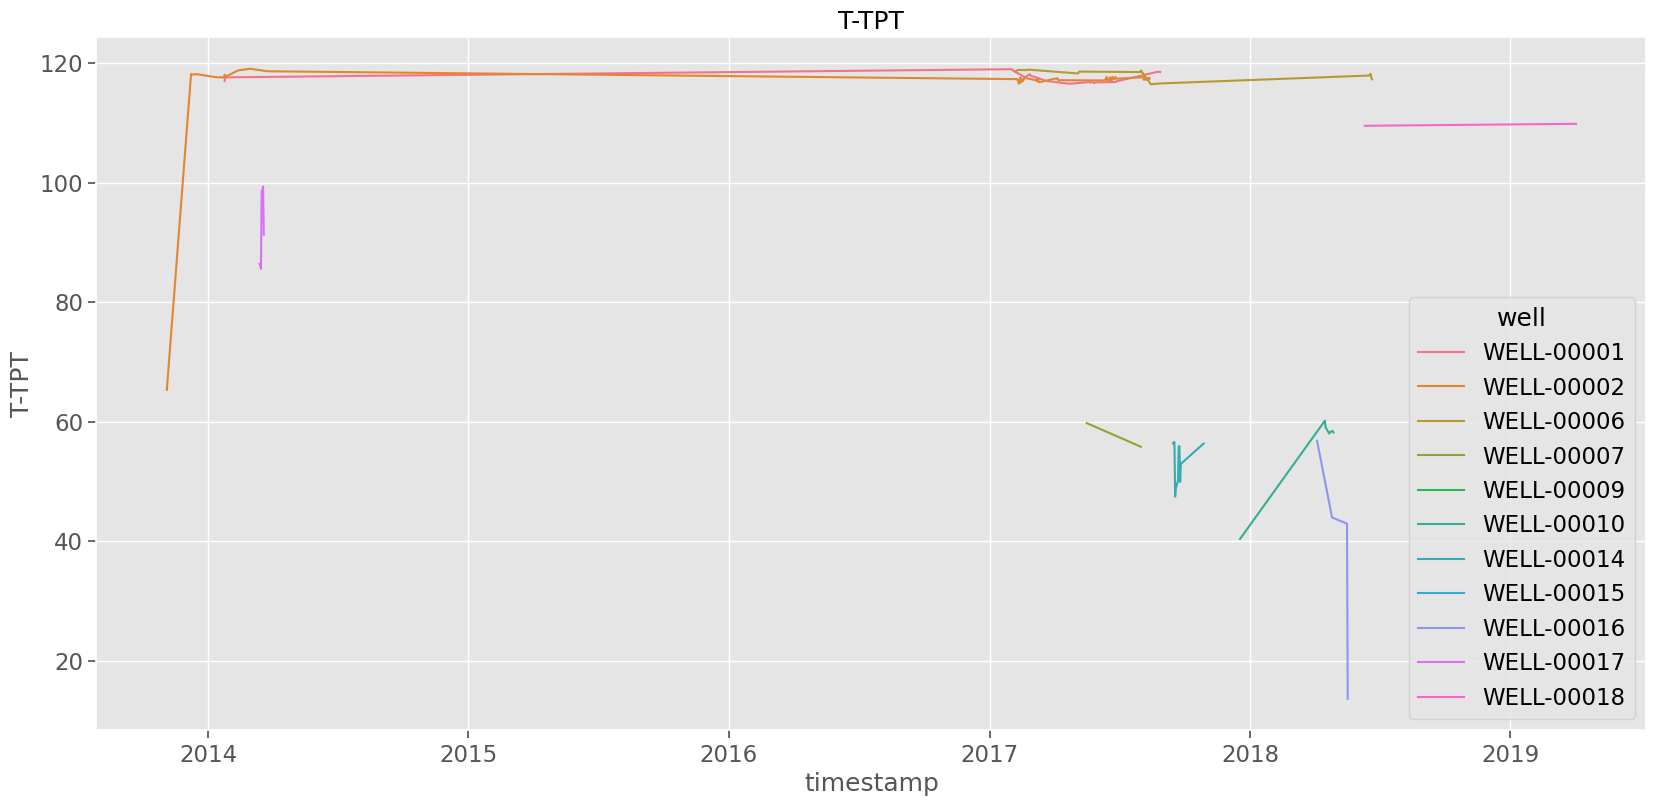

In [33]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='T-TPT', data=df4, hue='well')
plt.title('T-TPT')

Text(0.5, 1.0, 'T-JUS-CKP')

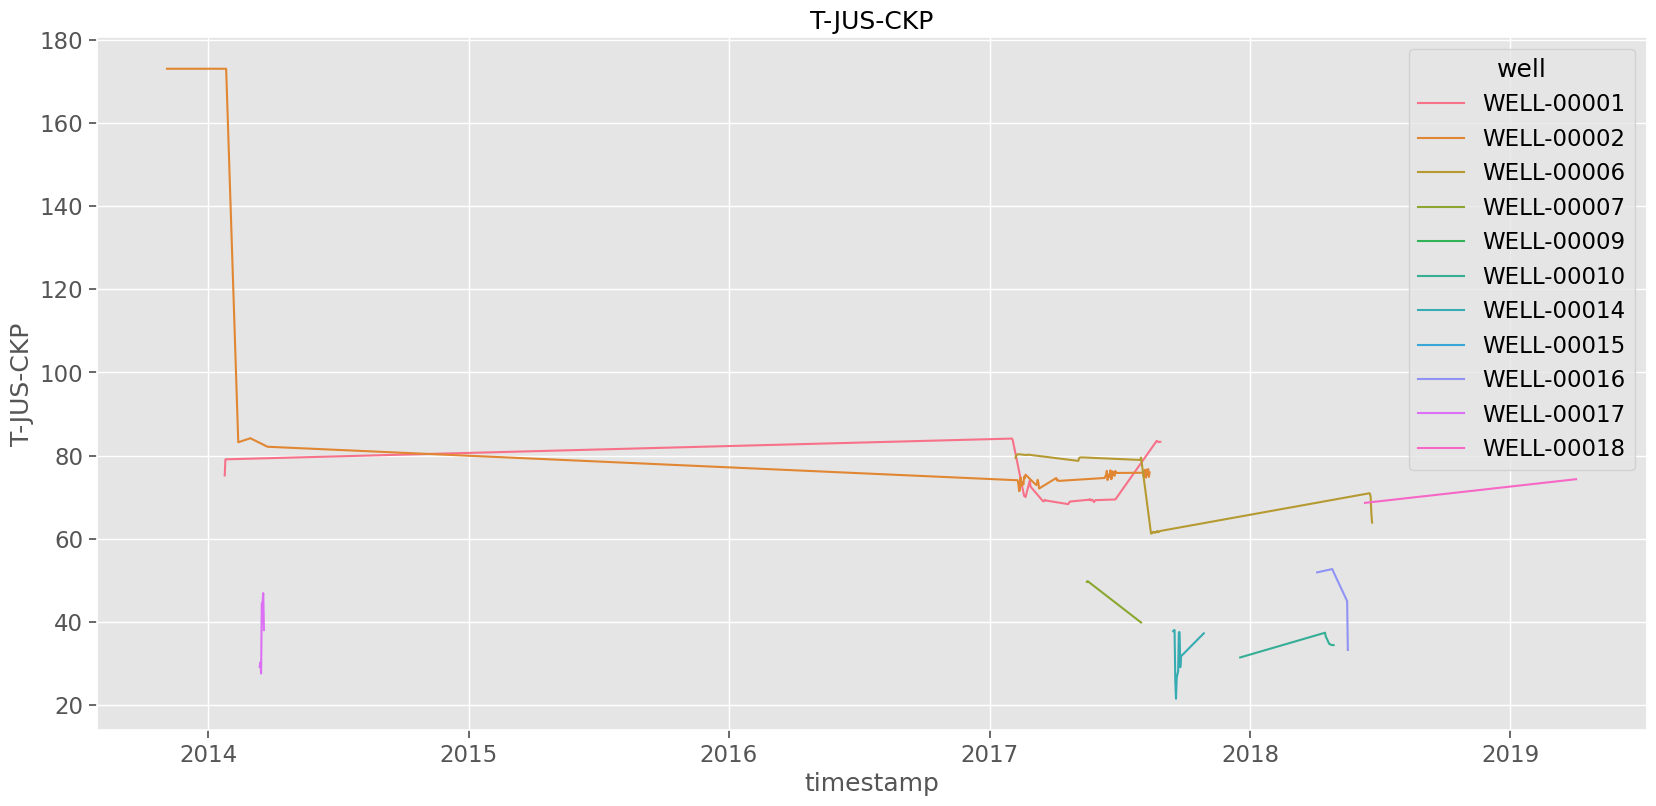

In [34]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='T-JUS-CKP', data=df4, hue='well')
plt.title('T-JUS-CKP')

Text(0.5, 1.0, 'P-JUS-CKGL')

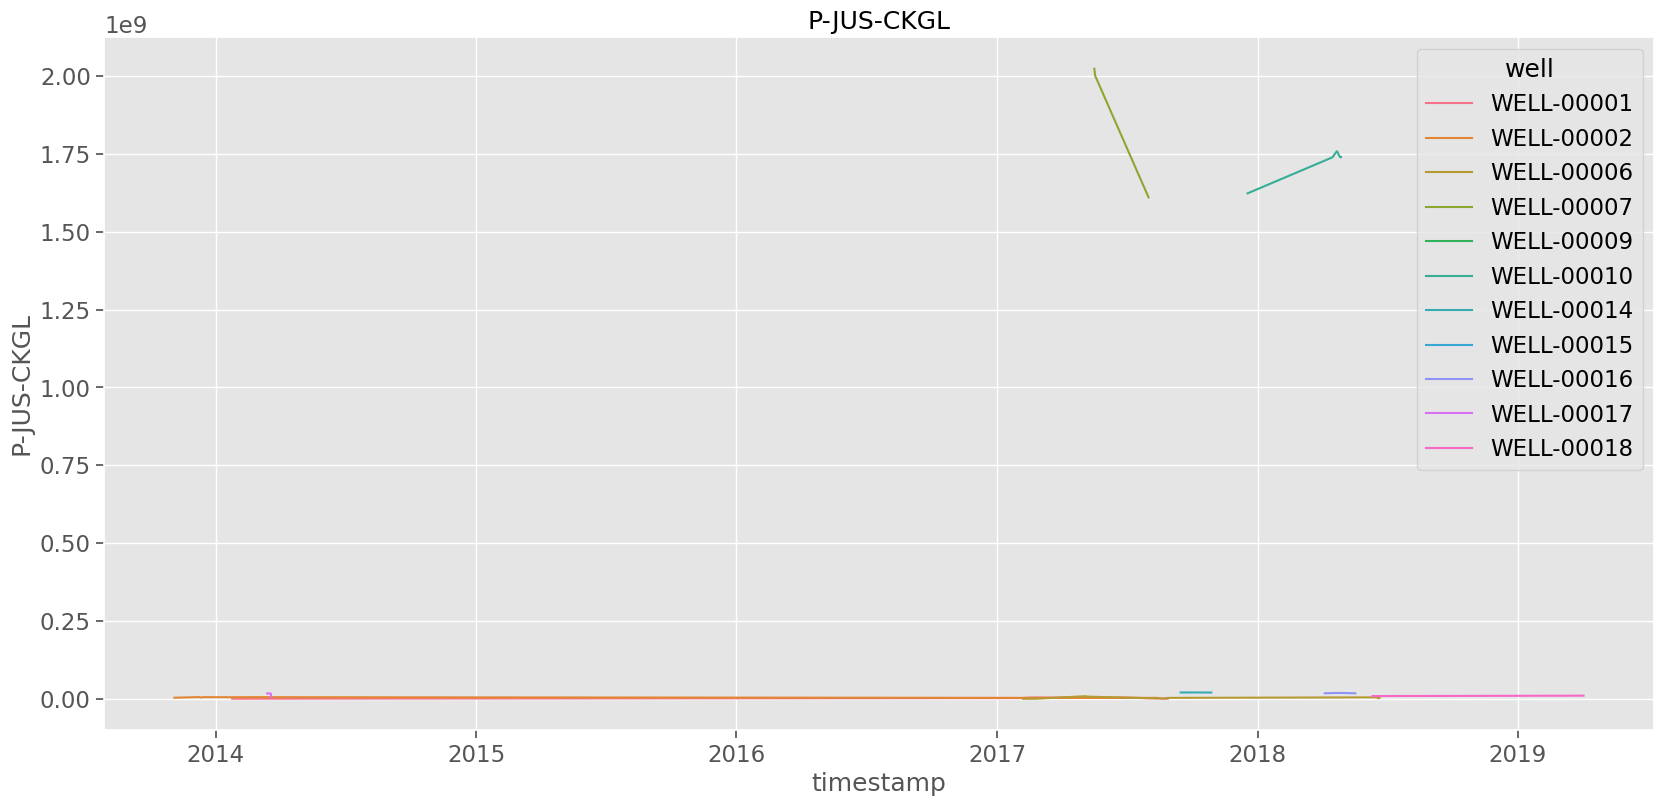

In [35]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-JUS-CKGL', data=df4, hue='well')
plt.title('P-JUS-CKGL')

Text(0.5, 1.0, 'P-MON-CKP')

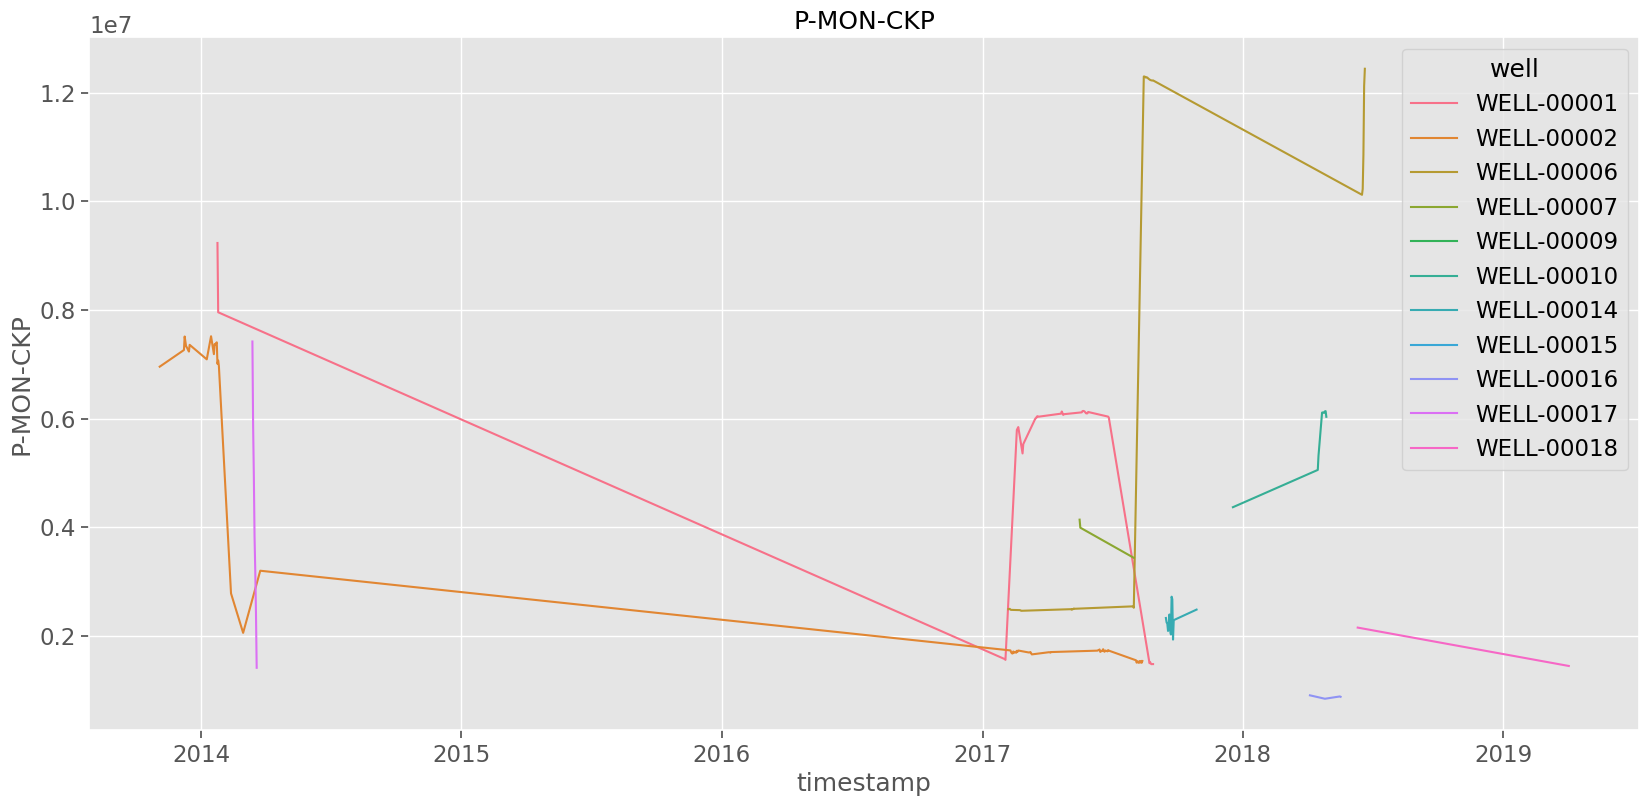

In [36]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='P-MON-CKP', data=df4, hue='well')
plt.title('P-MON-CKP')

Text(0.5, 1.0, 'QGL')

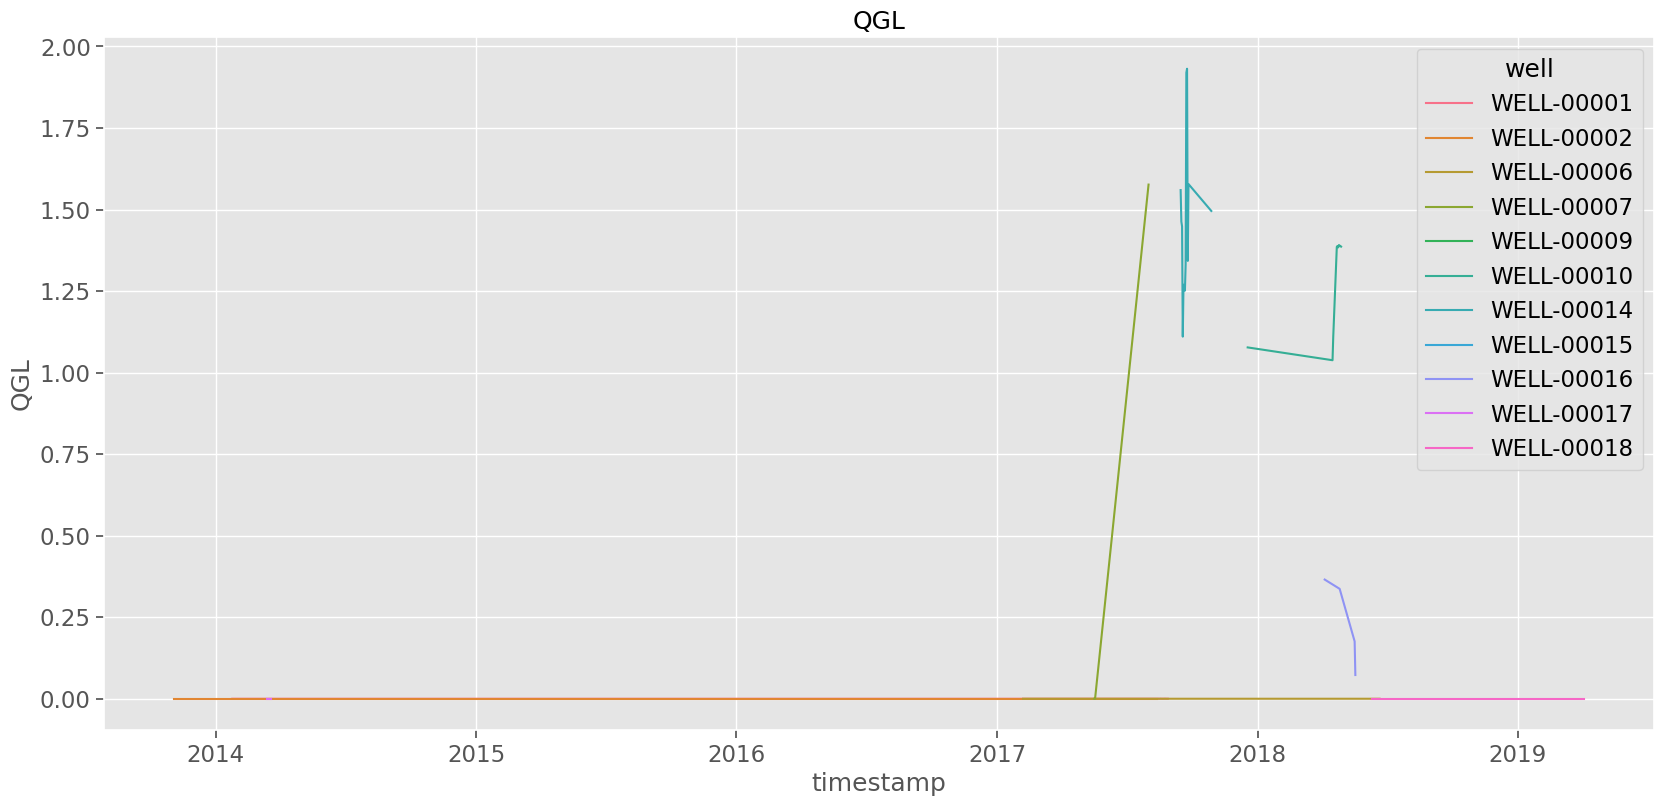

In [37]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='timestamp', y='QGL', data=df4, hue='well')
plt.title('QGL')